# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Data

In [2]:
df = pd.read_csv('dat.csv')
df.head()

,rider_id,request_id,ride_type,upfront_fare,eta_to_rider_pre_match,eta_to_rider_post_match,requested_at_local,accepted_at_local,cancellation_flag,cancel_penalty
0,///ED8ivQYKglW9pqPl3/Q==,NgwxDAgKVJUA97NcEMxbiQ==,standard,9.67,300.0,307,2019-05-24 17:40:05.000 America/Los_Angeles,2019-05-24 17:40:23.657 America/Los_Angeles,0,3
1,///ED8ivQYKglW9pqPl3/Q==,PL1ameHHmojZPMtcqYtwYw==,standard,25.88,402.0,49,2019-05-23 12:53:09.000 America/Los_Angeles,2019-05-23 12:53:18.073 America/Los_Angeles,0,3
2,//+BMX7AgO1U9LdzpaATcQ==,C4G4bkgdKJNCC4eDba7+fw==,standard,13.83,60.0,84,2019-04-24 00:34:23.000 America/Los_Angeles,2019-04-24 00:34:28.733 America/Los_Angeles,0,3
3,//0rVwc3CzbgklR6Nd0gvg==,EobERQ/51pMRobAL6PfSwA==,standard,16.21,60.0,127,2019-05-02 11:27:25.000 America/Los_Angeles,2019-05-02 11:27:34.165 America/Los_Angeles,0,5
4,//0rVwc3CzbgklR6Nd0gvg==,C+lhdANJupZL7X2OavmDpQ==,shared,8.96,337.0,225,2019-05-01 18:28:06.000 America/Los_Angeles,2019-05-01 18:28:30.988 America/Los_Angeles,0,5


# Data Preprocessing

In [3]:
#check for missing data
print(df.isna().sum())
#drop rows with missing data
df = df.dropna()

rider_id                       0
request_id                     0
ride_type                      0
upfront_fare                4862
eta_to_rider_pre_match     62317
eta_to_rider_post_match        0
requested_at_local             0
accepted_at_local              0
cancellation_flag              0
cancel_penalty                 0
dtype: int64


In [4]:
#drop request_id, its not useful
print(df['request_id'].is_unique) #check that all request_id are different, should say 'True'
df.drop(columns=['request_id'], inplace=True)

True


In [5]:
#get dummies from ride_type
df = pd.get_dummies(df, columns=['ride_type'], drop_first=True)

In [6]:
#get difference between eta_to_rider_pre_match and eta_to_rider_post_match
#a positive value indicates the eta became longer post match, a negative value indicates the eta became shorter post match
df['eta_difference'] = (df['eta_to_rider_post_match'] - df['eta_to_rider_pre_match'])

#drop eta_to_rider_pre_match and eta_to_rider_post_match, they are no longer needed
df.drop(columns=['eta_to_rider_pre_match', 'eta_to_rider_post_match'], inplace=True)

In [7]:
#separate requested_at_local and accepted_at_local into date and time
df[['requested_date', 'requested_time', 'requested_timezone']] = df['requested_at_local'].str.split(' ', expand=True).astype(str)
df[['accepted_date', 'accepted_time', 'accepted_timezone']] = df['accepted_at_local'].str.split(' ', expand=True).astype(str)

#drop requested_at_local and accepted_at_local, they are no longer needed
df.drop(columns=['requested_at_local', 'accepted_at_local'], inplace=True)

#check if any timezones are not 'America/Los_Angeles'
print(df[~df['requested_timezone'].isin(['America/Los_Angeles'])]['requested_timezone'].value_counts())
print(df[~df['accepted_timezone'].isin(['America/Los_Angeles'])]['accepted_timezone'].value_counts())

#drop timezone features, they are all the same
df.drop(columns=['requested_timezone', 'accepted_timezone'], inplace=True)

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


In [8]:
#combine requested_date/requested_time and accepted_date/accepted_time into a datetime formatted feature
df['requested_datetime'] = pd.to_datetime(df['requested_date'] + ' ' + df['requested_time'])
df['accepted_datetime'] = pd.to_datetime(df['accepted_date'] + ' ' + df['accepted_time'])

#drop columns that were used to make the datetime features, they are no longer needed
df.drop(columns=['requested_date', 'requested_time', 'accepted_date', 'accepted_time'], inplace=True)

In [9]:
#extract day of week and hour from requested_datetime to have as individual features
df['day_of_week'] = df['requested_datetime'].dt.dayofweek
df['hour'] = df['requested_datetime'].dt.hour

#get different between requested_datetime and accepted_datetime
df['accept_delay_seconds'] = (df['accepted_datetime'] - df['requested_datetime']).dt.total_seconds()

#drop datetime columns, they are no longer needed
df.drop(columns=['requested_datetime', 'accepted_datetime'], inplace=True)

### Creating new features based on hour and day of week

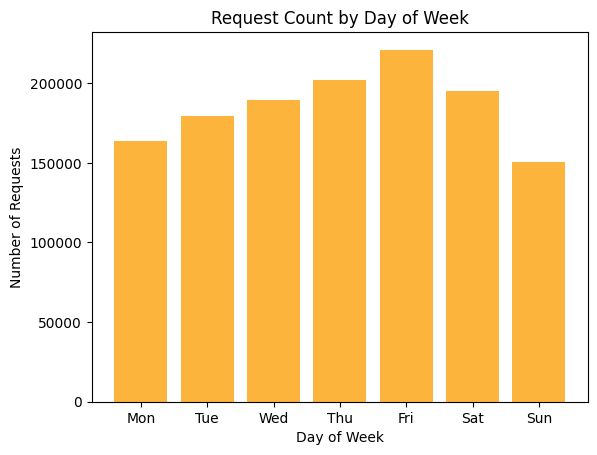

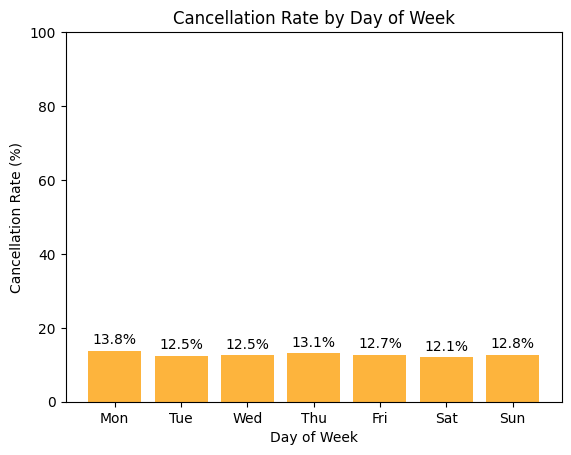

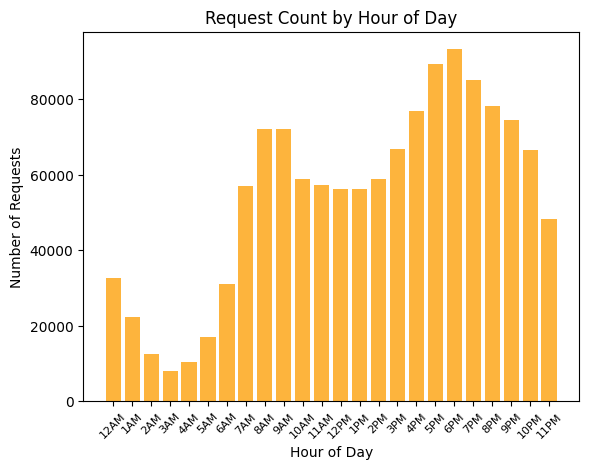

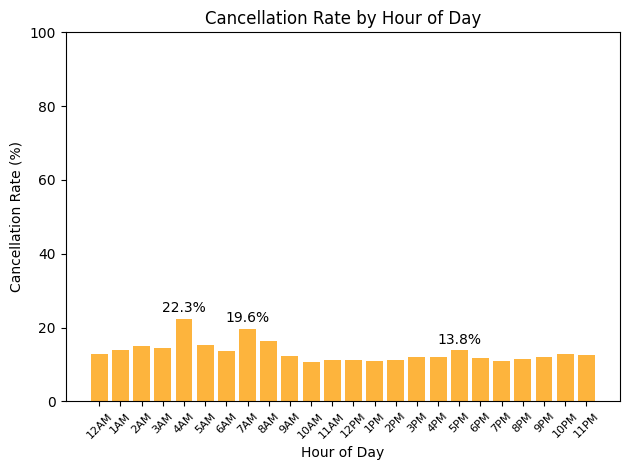

In [10]:
#number of requests per day of week
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_counts = df['day_of_week'].value_counts().sort_index()
plt.bar(days, day_counts, color='#fdb43d')
plt.title('Request Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Requests')
plt.xticks(rotation=0)
plt.show()

#percentage of cancellations by day of week
day_cancel_rate = df.groupby('day_of_week')['cancellation_flag'].mean().sort_index() * 100
bar1 = plt.bar(days, day_cancel_rate, color='#fdb43d')
plt.title('Cancellation Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=0)
plt.ylim(0, 100)
for i, bar in enumerate(bar1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom')
plt.show()


def hour_label(hour):
    suffix = 'AM' if hour < 12 else 'PM'
    hour_mod = hour % 12
    hour_mod = 12 if hour_mod == 0 else hour_mod
    return f'{hour_mod}{suffix}'

#number of requests per hour
hour_counts = df['hour'].value_counts().sort_index()
hours = [hour_label(h) for h in hour_counts.index]
plt.bar(hours, hour_counts, color='#fdb43d')
plt.title('Request Count by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45, fontsize=8)
plt.show()

#percentage of cancellations by hour of day
hour_cancel_rate = df.groupby('hour')['cancellation_flag'].mean().sort_index() * 100
bar2 = plt.bar(hours, hour_cancel_rate, color='#fdb43d')
plt.title('Cancellation Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45, fontsize=8)
plt.ylim(0, 100)
for i, bar in enumerate(bar2):
    if i == 4 or i == 7 or i == 17:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [11]:
#print(hour_cancel_rate.sort_values())

In [12]:
#create dummy variables representing weekday vs weekend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')
df['is_weekend'] = df['is_weekend'].astype('category')
df = pd.get_dummies(df, columns=['is_weekend'], drop_first=True)

#create dummy variables representing rush hour vs non rush hour
#we define rush hour as 8am, 9am, 5pm, 6pm, 7pm
df['is_rush_hour'] = df['hour'].apply(lambda x: 'rush' if (8 <= x <= 9) or (17 <= x <= 19) else 'non-rush')
df['is_rush_hour'] = df['is_rush_hour'].astype('category')
df = pd.get_dummies(df, columns=['is_rush_hour'], drop_first=True)

In [13]:
df.head()

,rider_id,upfront_fare,cancellation_flag,cancel_penalty,ride_type_standard,eta_difference,day_of_week,hour,accept_delay_seconds,is_weekend_weekend,is_rush_hour_rush
0,///ED8ivQYKglW9pqPl3/Q==,9.67,0,3,True,7.0,4,17,18.657,False,True
1,///ED8ivQYKglW9pqPl3/Q==,25.88,0,3,True,-353.0,3,12,9.073,False,False
2,//+BMX7AgO1U9LdzpaATcQ==,13.83,0,3,True,24.0,2,0,5.733,False,False
3,//0rVwc3CzbgklR6Nd0gvg==,16.21,0,5,True,67.0,3,11,9.165,False,False
4,//0rVwc3CzbgklR6Nd0gvg==,8.96,0,5,False,-112.0,2,18,24.988,False,True


# Classification Model

In [14]:
df_class = df.drop(columns=['rider_id'])

The hours with the highest cancellation rate were 4, 7, and 8am so we made a separate dummy variable just for that.

In [15]:
df_class['is_morning'] = df_class['hour'].apply(lambda x: 'morning' if (x==4) or (x==7) or (x==8) else 'non-morning')
df_class['is_morning'] = df_class['is_morning'].astype('category')
df_class = pd.get_dummies(df_class, columns=['is_morning'], drop_first=True)

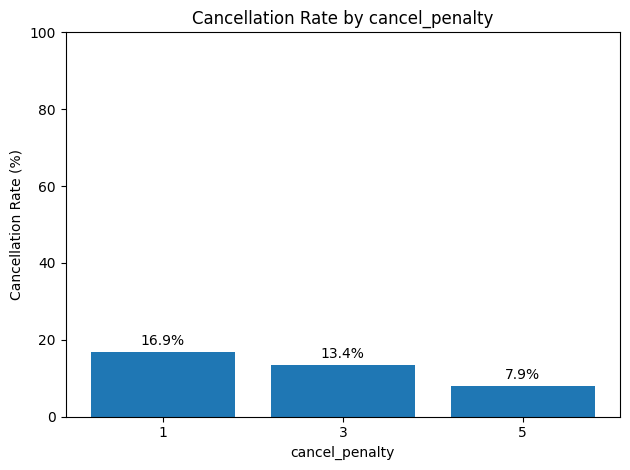

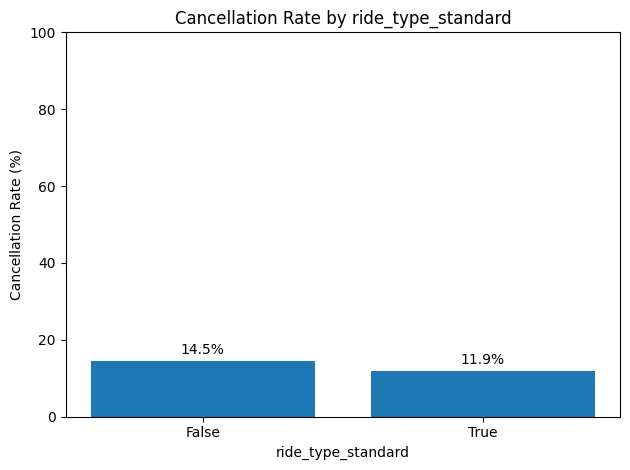

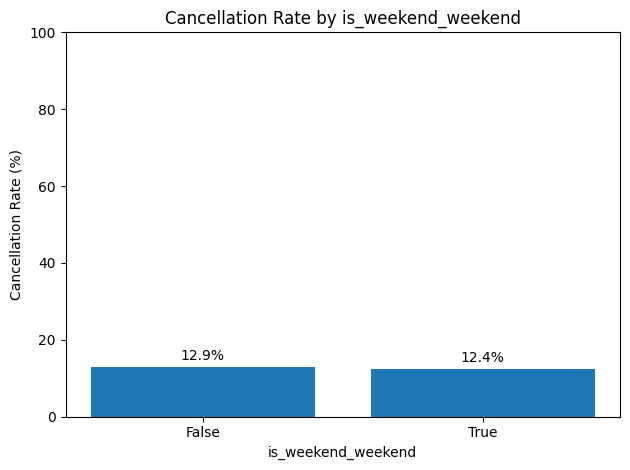

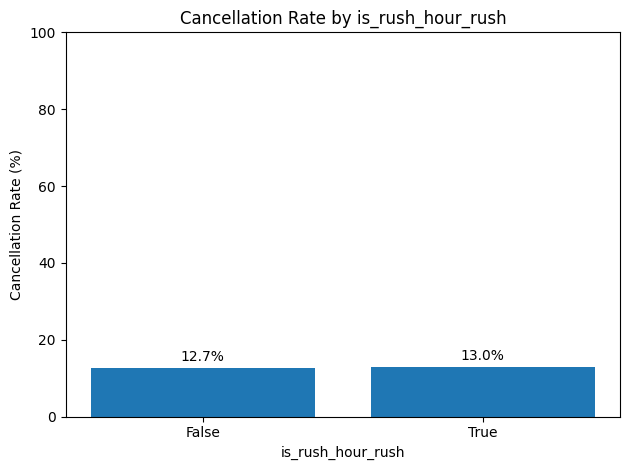

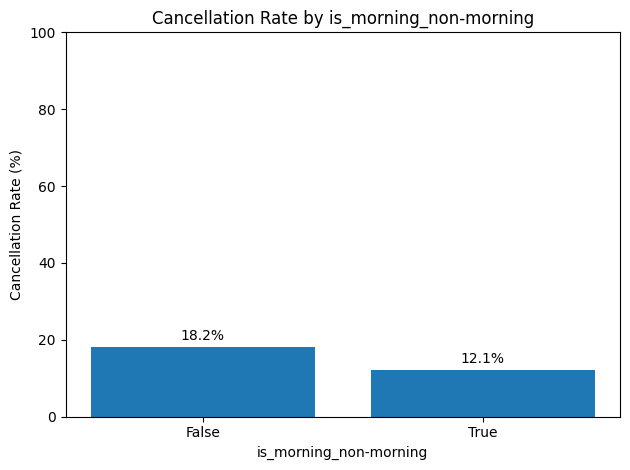

In [16]:
def plot_cancel_rate(feature):
    rate_df = df_class.groupby(feature)['cancellation_flag'].mean().sort_index() * 100
    labels = rate_df.index.astype(str)
    bars = plt.bar(labels, rate_df.values)
    plt.title(f'Cancellation Rate by {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Cancellation Rate (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=0)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

#percentage of cancellations for all categorical features
c_features = ['cancel_penalty', 'ride_type_standard', 'is_weekend_weekend', 'is_rush_hour_rush', 'is_morning_non-morning']
for f in c_features:
    plot_cancel_rate(f)

In [17]:
df_class.head()

,upfront_fare,cancellation_flag,cancel_penalty,ride_type_standard,eta_difference,day_of_week,hour,accept_delay_seconds,is_weekend_weekend,is_rush_hour_rush,is_morning_non-morning
0,9.67,0,3,True,7.0,4,17,18.657,False,True,True
1,25.88,0,3,True,-353.0,3,12,9.073,False,False,True
2,13.83,0,3,True,24.0,2,0,5.733,False,False,True
3,16.21,0,5,True,67.0,3,11,9.165,False,False,True
4,8.96,0,5,False,-112.0,2,18,24.988,False,True,True


### Creating features for numerical variables

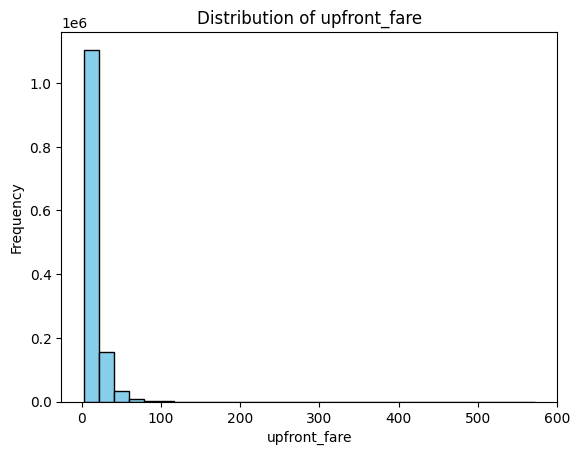

Mean of upfront_fare is 13.841107224666285
Median of upfront_fare is 10.37


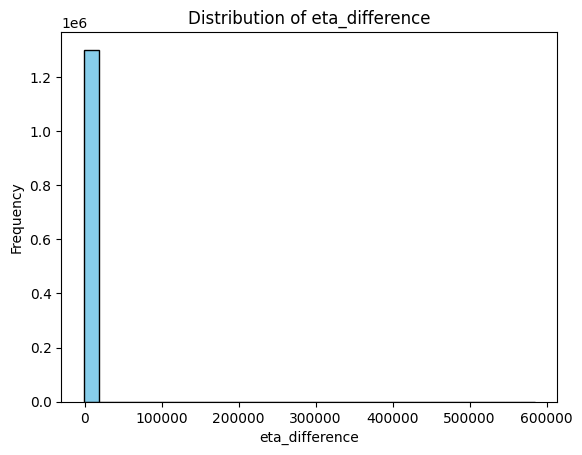

Mean of eta_difference is 3.901808182318715
Median of eta_difference is 12.0


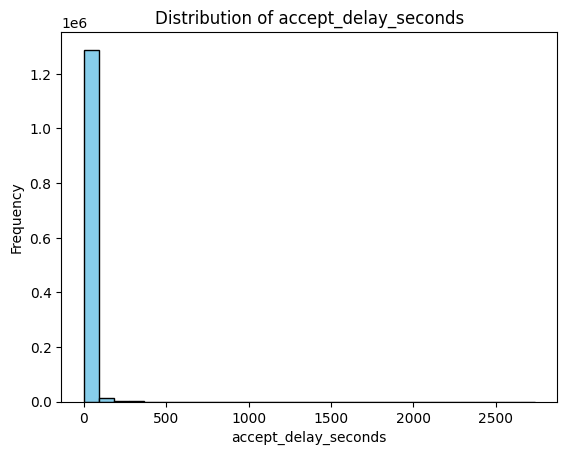

Mean of accept_delay_seconds is 18.215102069730246
Median of accept_delay_seconds is 13.742


In [18]:
def custom_histogram(feature):
    plt.hist(df_class[feature], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.show()

numerical_features = ['upfront_fare', 'eta_difference', 'accept_delay_seconds']
for n in numerical_features:
    custom_histogram(n)
    print(f'Mean of {n} is {df_class[n].mean()}')
    print(f'Median of {n} is {df_class[n].median()}')

Splitting the data repeatedly until I find a large difference in cancellation rates.

C:\Users\eliss\AppData\Local\Temp\ipykernel_28368\1849141589.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_cancel_rate = df_class.groupby('fare_bin')['cancellation_flag'].mean() * 100


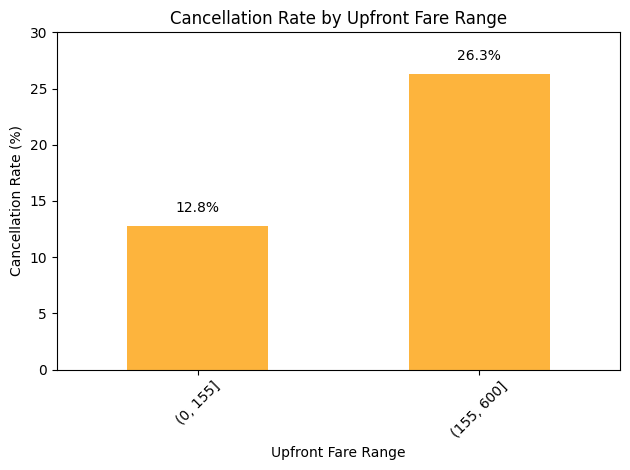

In [19]:
df_class['fare_bin'] = pd.cut(df_class['upfront_fare'], bins=[0, 155, 600])
fare_cancel_rate = df_class.groupby('fare_bin')['cancellation_flag'].mean() * 100

ax = fare_cancel_rate.plot(kind='bar', color='#fdb43d')
plt.title('Cancellation Rate by Upfront Fare Range')
plt.xlabel('Upfront Fare Range')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.ylim(0, 30)

for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom' )

plt.tight_layout()
plt.show()

### Conclusion: Above $155 upfront fare has more cancellations

C:\Users\eliss\AppData\Local\Temp\ipykernel_28368\1604517349.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eta_cancel_rate = df_class.groupby('eta_difference_bin')['cancellation_flag'].mean() * 100


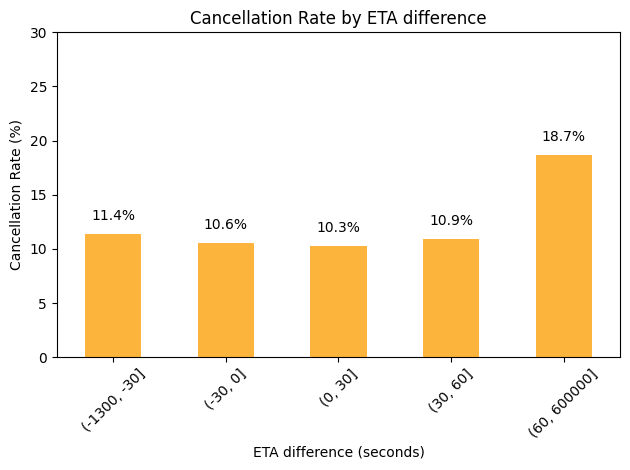

In [20]:
df_class['eta_difference_bin'] = pd.cut(df_class['eta_difference'], bins=[-1300, -30, 0, 30, 60, 600000])
eta_cancel_rate = df_class.groupby('eta_difference_bin')['cancellation_flag'].mean() * 100

ax = eta_cancel_rate.plot(kind='bar', color='#fdb43d')
plt.title('Cancellation Rate by ETA difference')
plt.xlabel('ETA difference (seconds)')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.ylim(0, 30)
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom' )
plt.tight_layout()
plt.show()

### Conclusion: Above 1 minute waiting time has more cancellations

C:\Users\eliss\AppData\Local\Temp\ipykernel_28368\3676848775.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_cancel_rate = df_class.groupby('accept_delay_bin')['cancellation_flag'].mean() * 100


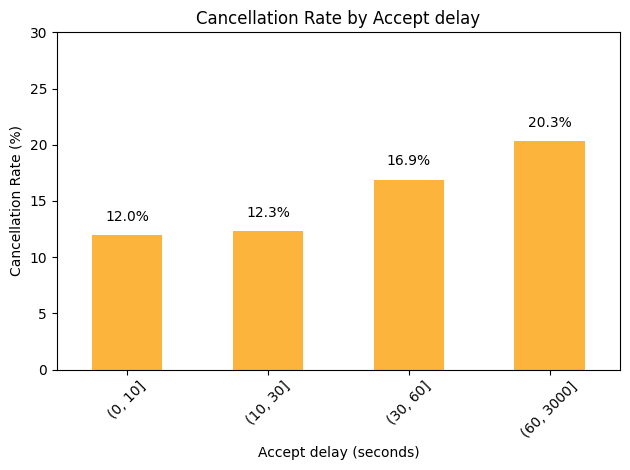

In [21]:
df_class['accept_delay_bin'] = pd.cut(df_class['accept_delay_seconds'], bins=[0, 10, 30, 60, 3000])
delay_cancel_rate = df_class.groupby('accept_delay_bin')['cancellation_flag'].mean() * 100

ax = delay_cancel_rate.plot(kind='bar', color='#fdb43d')
plt.title('Cancellation Rate by Accept delay')
plt.xlabel('Accept delay (seconds)')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.ylim(0, 30)
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom' )
plt.tight_layout()
plt.show()

### Conclusion: Above 30 second waiting time has more cancellations

In [22]:
#creating more categorical variables
df_class['high_fare'] = df_class['upfront_fare'].apply(lambda x: 'fare above 155' if (x>=155) else 'low fare')
df_class['high_fare'] = df_class['high_fare'].astype('category')
df_class = pd.get_dummies(df_class, columns=['high_fare'], drop_first=True)

df_class['high_eta'] = df_class['eta_difference'].apply(lambda x: 'wait above 60' if (x>=60) else 'low wait')
df_class['high_eta'] = df_class['high_eta'].astype('category')
df_class = pd.get_dummies(df_class, columns=['high_eta'], drop_first=True)

df_class['high_delay'] = df_class['accept_delay_seconds'].apply(lambda x: 'delay above 30' if (x>=30) else 'low delay')
df_class['high_delay'] = df_class['high_delay'].astype('category')
df_class = pd.get_dummies(df_class, columns=['high_delay'], drop_first=True)

In [23]:
df_class.head()

,upfront_fare,cancellation_flag,cancel_penalty,ride_type_standard,eta_difference,day_of_week,hour,accept_delay_seconds,is_weekend_weekend,is_rush_hour_rush,is_morning_non-morning,fare_bin,eta_difference_bin,accept_delay_bin,high_fare_low fare,high_eta_wait above 60,high_delay_low delay
0,9.67,0,3,True,7.0,4,17,18.657,False,True,True,"(0, 155]","(0, 30]","(10, 30]",True,False,True
1,25.88,0,3,True,-353.0,3,12,9.073,False,False,True,"(0, 155]","(-1300, -30]","(0, 10]",True,False,True
2,13.83,0,3,True,24.0,2,0,5.733,False,False,True,"(0, 155]","(0, 30]","(0, 10]",True,False,True
3,16.21,0,5,True,67.0,3,11,9.165,False,False,True,"(0, 155]","(60, 600000]","(0, 10]",True,True,True
4,8.96,0,5,False,-112.0,2,18,24.988,False,True,True,"(0, 155]","(-1300, -30]","(10, 30]",True,False,True


### Fix categorical variables

In [24]:
df_class['ride_type_standard'] = df_class['ride_type_standard'].astype("category")
df_class['day_of_week'] = df_class['day_of_week'].astype("category")
df_class['hour'] = df_class['hour'].astype("category")
df_class['is_weekend_weekend'] = df_class['is_weekend_weekend'].astype("category")
df_class['is_rush_hour_rush'] = df_class['is_rush_hour_rush'].astype("category")
df_class['is_morning_non-morning'] = df_class['is_morning_non-morning'].astype("category")
df_class['high_fare_low fare'] = df_class['high_fare_low fare'].astype("category")
df_class['high_eta_wait above 60'] = df_class['high_eta_wait above 60'].astype("category")
df_class['high_delay_low delay'] = df_class['high_delay_low delay'].astype("category")

In [25]:
print("All columns:")
print(df_class.columns.tolist())
numeric_cols = df_class.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_class.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric columns:")
print(numeric_cols)
print("\nCategorical columns:")
print(categorical_cols)


All columns:
['upfront_fare', 'cancellation_flag', 'cancel_penalty', 'ride_type_standard', 'eta_difference', 'day_of_week', 'hour', 'accept_delay_seconds', 'is_weekend_weekend', 'is_rush_hour_rush', 'is_morning_non-morning', 'fare_bin', 'eta_difference_bin', 'accept_delay_bin', 'high_fare_low fare', 'high_eta_wait above 60', 'high_delay_low delay']

Numeric columns:
['upfront_fare', 'cancellation_flag', 'cancel_penalty', 'eta_difference', 'accept_delay_seconds']

Categorical columns:
['ride_type_standard', 'day_of_week', 'hour', 'is_weekend_weekend', 'is_rush_hour_rush', 'is_morning_non-morning', 'fare_bin', 'eta_difference_bin', 'accept_delay_bin', 'high_fare_low fare', 'high_eta_wait above 60', 'high_delay_low delay']


In [26]:
#separate result from other features
df_class.drop(columns=['fare_bin', 'eta_difference_bin', 'accept_delay_bin'], inplace=True)

X = df_class.drop(columns=['cancellation_flag'])
y = df_class['cancellation_flag']

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

#preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

#split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Confusion Matrix:
 [[225321   1906]
 [ 32000   1223]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93    227227
           1       0.39      0.04      0.07     33223

    accuracy                           0.87    260450
   macro avg       0.63      0.51      0.50    260450
weighted avg       0.81      0.87      0.82    260450



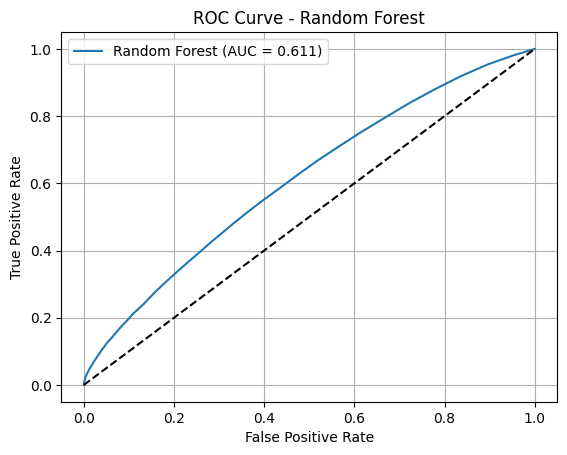

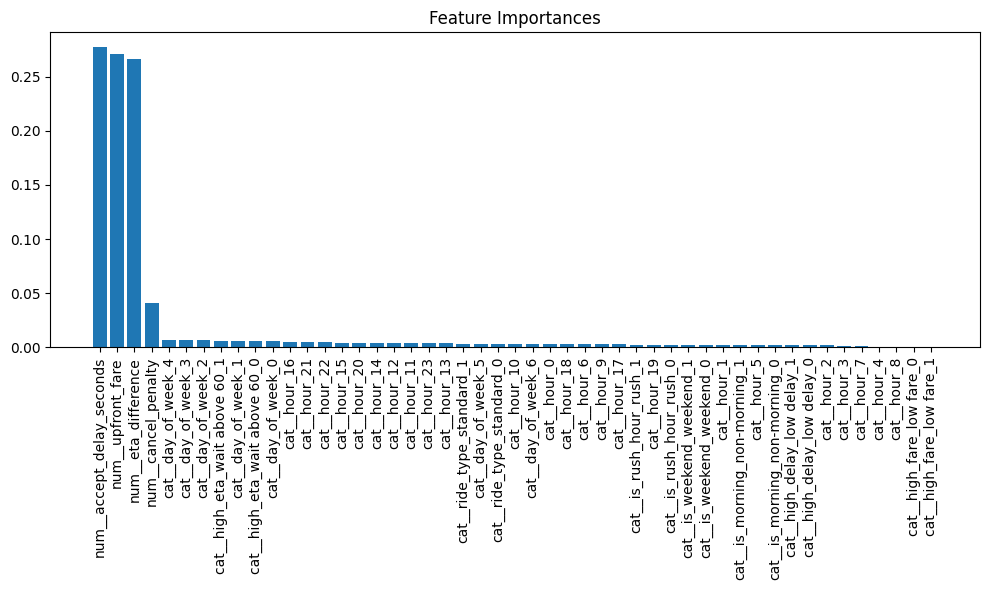

In [ ]:
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

rf_model = rf_pipeline.named_steps['classifier']
feature_names = rf_pipeline.named_steps['preprocessing'].get_feature_names_out()
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

### Retraining the model with limited features

In [27]:
df_class.drop(columns=['day_of_week', 'hour'], inplace=True)

X_limited = df_class.drop(columns=['cancellation_flag'])
y = df_class['cancellation_flag']

numeric_cols = X_limited.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_limited.select_dtypes(include=['object', 'category']).columns.tolist()

Confusion Matrix:
 [[225033   2194]
 [ 31936   1287]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93    227227
           1       0.37      0.04      0.07     33223

    accuracy                           0.87    260450
   macro avg       0.62      0.51      0.50    260450
weighted avg       0.81      0.87      0.82    260450



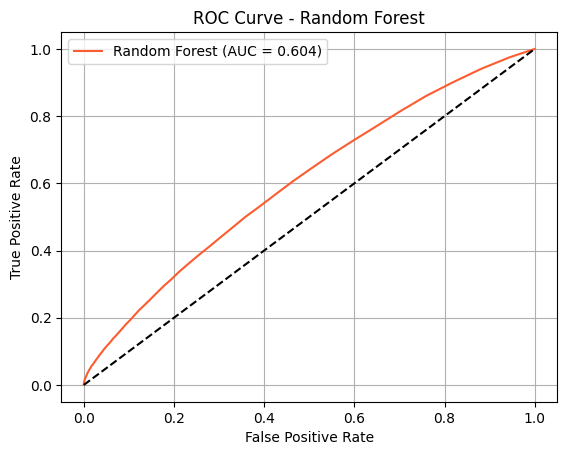

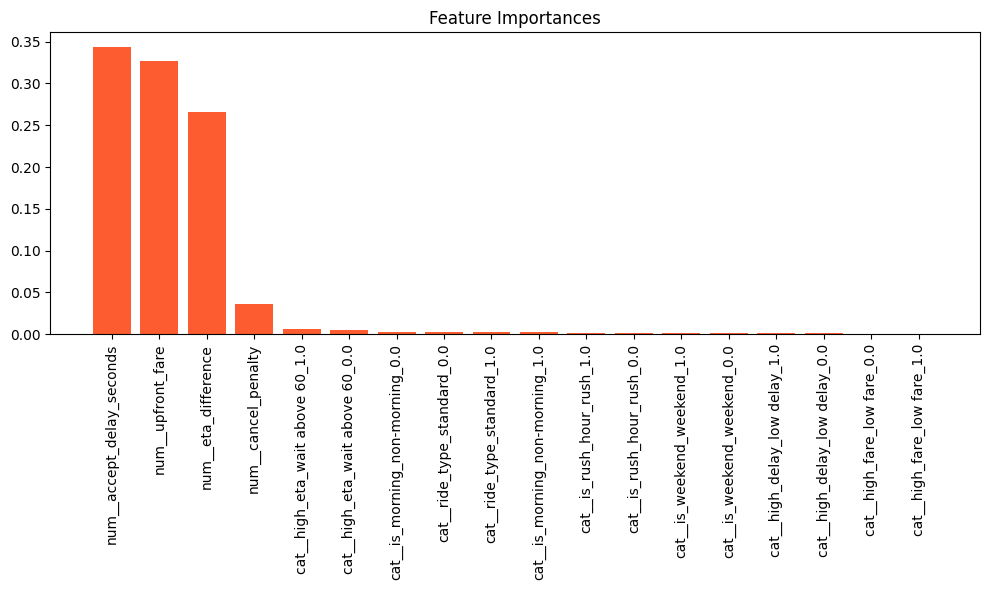

In [28]:
#preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X_limited, y, test_size=0.2, random_state=42, stratify=y)

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_score:.3f})", color='#fc5c30')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

rf_model = rf_pipeline.named_steps['classifier']
feature_names = rf_pipeline.named_steps['preprocessing'].get_feature_names_out()
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], color='#fc5c30')
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Regression Model

In [29]:
df_reg = df

In [30]:
# compute number of requests per rider
# for each unique rider, count how many ride requests they have made.
# total (num_requests) will be the prediction target the regression task.
rider_counts = df_reg.groupby('rider_id').size().reset_index(name='num_requests')

In [31]:
# for each rider, computes the mean (average) value of important ride features,
# capturing their ride characteristics.
numeric_cols = ['upfront_fare', 'cancel_penalty', 'eta_difference',
                'day_of_week', 'hour', 'accept_delay_seconds']
agg_features = df_reg.groupby('rider_id')[numeric_cols].mean().reset_index()

In [32]:
# include encoded ride_type if available
ride_type_cols = [col for col in df_reg.columns if col.startswith('ride_type_')]
if ride_type_cols:
    ride_type_agg = df_reg.groupby('rider_id')[ride_type_cols].mean().reset_index()
    agg_features = agg_features.merge(ride_type_agg, on='rider_id', how='left')

In [33]:
# combines the per-rider features and the total request count (num_requests)
# into one dataset for modeling.
df_rider = agg_features.merge(rider_counts, on='rider_id', how='left')

In [34]:
# separates the data into predictor variables X and the
# regression target y, which is the total number of requests per rider.
X_reg = df_rider.drop(columns=['rider_id', 'num_requests'])
y_reg = df_rider['num_requests']

In [35]:
# splits the data into training and testing sets 80%/20%
# for evaluating model performance.
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

In [36]:
# standardizes the features so they have mean 0 and variance 1,
# which helps Random Forests perform optimally.
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

In [37]:
# creates and trains a Random Forest model to learn the relationship
# between rider features and the number of ride requests.
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_reg_scaled, y_train_reg)

RandomForestRegressor(random_state=42)

In [38]:
# predict and evaluate
y_pred_reg = reg.predict(X_test_reg_scaled)

In [39]:
print("Regression Metrics:")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R^2 Score:", r2_score(y_test_reg, y_pred_reg))

Regression Metrics:
MAE: 0.5480369394201556
RMSE: 1.3163524832388804
R^2 Score: 0.8093021262478659


In [40]:
importances = pd.Series(reg.feature_importances_, index=X_reg.columns)
print("\nFeature Importances:")
print(importances.sort_values(ascending=False))


Feature Importances:
ride_type_standard      0.447571
day_of_week             0.342926
hour                    0.071422
accept_delay_seconds    0.046126
upfront_fare            0.044712
eta_difference          0.040615
cancel_penalty          0.006628
dtype: float64


In [41]:
# sample test (the first test rider)
sample_features = X_test_reg.iloc[0]

# reshape for model (2D)
sample_features_array = sample_features.values.reshape(1, -1)
# scale with the same scaler used for training
sample_features_scaled = scaler_reg.transform(sample_features_array)
# predict with trained model
predicted_requests = reg.predict(sample_features_scaled)

print(f"Predicted number of ride requests for this rider: {predicted_requests[0]:.2f}")


Predicted number of ride requests for this rider: 1.41


C:\Users\eliss\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


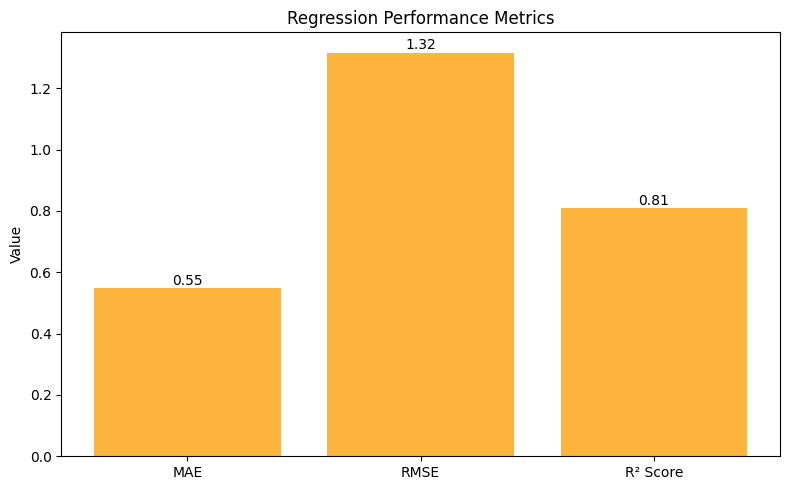

In [42]:
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

metrics = {'MAE': mae, 'RMSE': rmse, 'R² Score': r2}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='#fdb43d')
plt.title('Regression Performance Metrics')
plt.ylabel('Value')

for i, (k, v) in enumerate(metrics.items()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

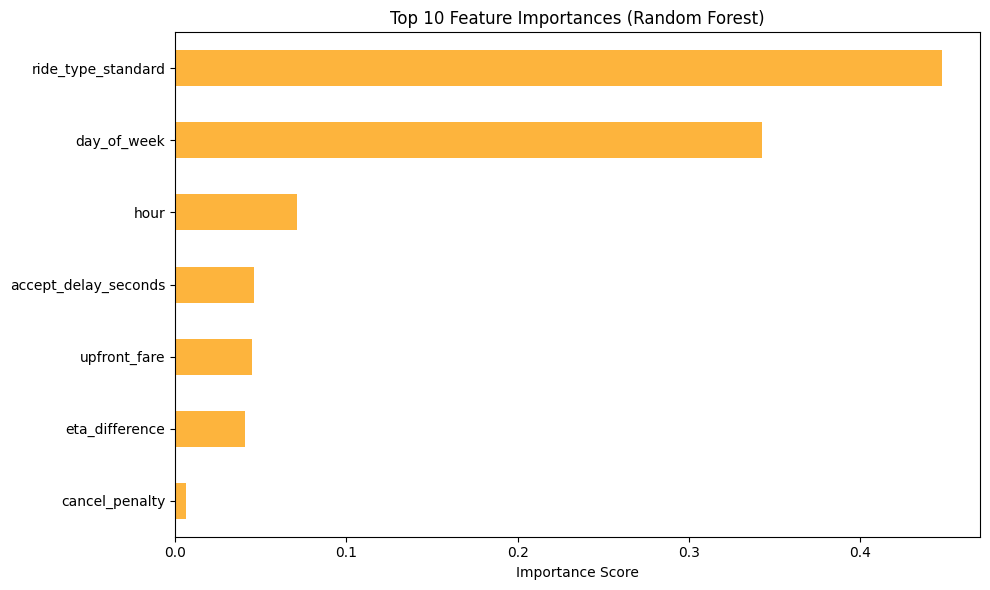

In [43]:
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='#fdb43d')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()